In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb

from sklearn.model_selection import GridSearchCV,RepeatedKFold,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, auc, RocCurveDisplay,roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
np.random.seed(10)

In [15]:
df = pd.read_csv("../results/gene_exp_analysis/lasso_selected_count.csv",
                 header=0,sep="\t")
label = pd.read_csv("../results/gene_exp_analysis/clinical.csv",
                    header=0,sep="\t")

# Data preprocessing 

In [16]:
label["OS"].value_counts()

OS
0    189
1    103
Name: count, dtype: int64

Here we used StandardScaler to standard the data.

In [18]:
scaler = StandardScaler()
genes_ensemble_id = df["genes"]
df_no_gene = df.drop(["genes"],axis=1)
final_df = df_no_gene.T
final_df.columns = genes_ensemble_id
#final_df["stage"] = label["stage"].values
scaled_final_df = scaler.fit_transform(final_df)

In [19]:
y= label["OS"].values

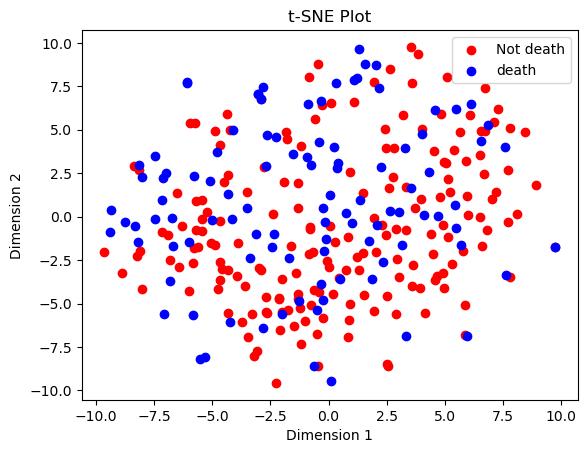

In [20]:
from sklearn.manifold import TSNE
# Assuming your data is stored in the variable 'data'
tsne = TSNE(n_components=2)
embedded_data = tsne.fit_transform(scaled_final_df)

# Step 2: Separate data points by class
class_1_indices = np.where(y == 0)[0]
class_2_indices = np.where(y == 1)[0]

class_1_data = embedded_data[class_1_indices]
class_2_data = embedded_data[class_2_indices]

# Step 3: Plot the t-SNE plot with different colors for each class
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], color='red', label='Not death')
plt.scatter(class_2_data[:, 0], class_2_data[:, 1], color='blue', label='death')

plt.title('t-SNE Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

We can see that the tSNE plot did't give us any information about clustering between survival and non-survival

# Split train and test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(scaled_final_df, y, test_size=0.4)

In [22]:
np.unique(y_train,return_counts=True),np.unique(y_test,return_counts=True),

((array([0, 1]), array([113,  62])), (array([0, 1]), array([76, 41])))

In [23]:
np.unique(y_train,return_counts=True)[1],np.unique(y_test,return_counts=True)[1]

(array([113,  62]), array([76, 41]))

The number of samples in survival and non-survival are significantly different. Hence we will use oversampling on the training set.

## Over sampling

In [24]:
over_sample= np.unique(y_train,return_counts=True)[1][0] if np.unique(y_train,return_counts=True)[1][0] > np.unique(y_train,return_counts=True)[1][1] else np.unique(y_train,return_counts=True)[1][1]

synthetic_samples = {
    0: over_sample,  # Number of synthetic samples for class 1
    1: over_sample,  # Number of synthetic samples for class 2
    # Add more classes and desired synthetic sample counts as needed
}
smote = SMOTE(sampling_strategy=synthetic_samples)
X_train,y_train = smote.fit_resample(X_train, y_train)

In [25]:
def training(x,y,model,param_grid):
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 1)
    grid.fit(X_train, y_train)
    trained_model = grid.best_estimator_
    trained_model.fit(X_train,y_train)
    return trained_model

In [26]:
def roc(X_train,y_train,model,label):
    cv = StratifiedKFold(n_splits=5)
    classifier = model
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
        #classifier.fit(X_train.iloc[train], y_train[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_train.iloc[test],
            y_train[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=label,
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

# Applying ML models

## Randomforest

In [27]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(random_state=7)

# defining parameter range
param_grid = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10,12,14,16,20],
    'criterion' :['gini', 'entropy']
}
rf_model = training(X_train,y_train,model,param_grid)
y_predict = rf_model.predict(X_test)
y_train_predict = rf_model.predict(X_train)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_train, y_train_predict))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        76
           1       0.60      0.44      0.51        41

    accuracy                           0.70       117
   macro avg       0.67      0.64      0.65       117
weighted avg       0.69      0.70      0.69       117

[[64 12]
 [23 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00       113

    accuracy                           1.00       226
   macro avg       1.00      1.00      1.00       226
weighted avg       1.00      1.00      1.00       226



Since the training gives us 1 in all metrics, and testing gives us quite low values. The model seems overfitted. One assumption here is that the sample size is >> than number of features

In [40]:
rf_model

RandomForestClassifier(max_depth=10, max_features='log2', random_state=7)

Best parameters from gridsearchCV

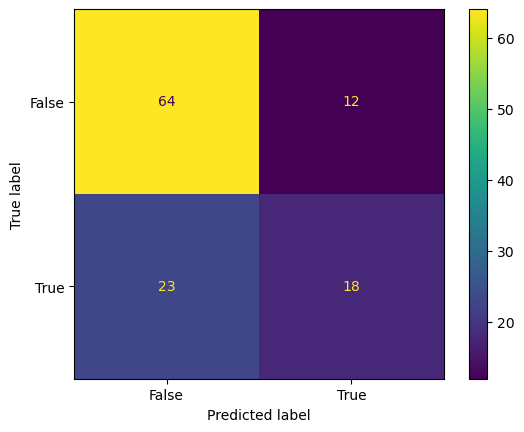

In [39]:
from sklearn import metrics
y_test_pred_xgb = rf_model.predict(X_test)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
cm_display.plot()
plt.show()

In [28]:
important_feat = rf_model.feature_importances_
#get indices of those important features
feature_df = pd.DataFrame({"genes": genes_ensemble_id,"importance": important_feat})

In [29]:
sort_feature_df = feature_df.sort_values("importance",ascending=False)
sort_feature_df

genes  importance
192  ENSG00000150764    0.016804
56   ENSG00000113657    0.012486
87   ENSG00000125895    0.012106
140  ENSG00000137693    0.011911
235  ENSG00000162520    0.010856
..               ...         ...
37   ENSG00000103061    0.000642
226  ENSG00000160994    0.000471
212  ENSG00000156885    0.000465
67   ENSG00000118702    0.000463
177  ENSG00000146385    0.000158

[243 rows x 2 columns]

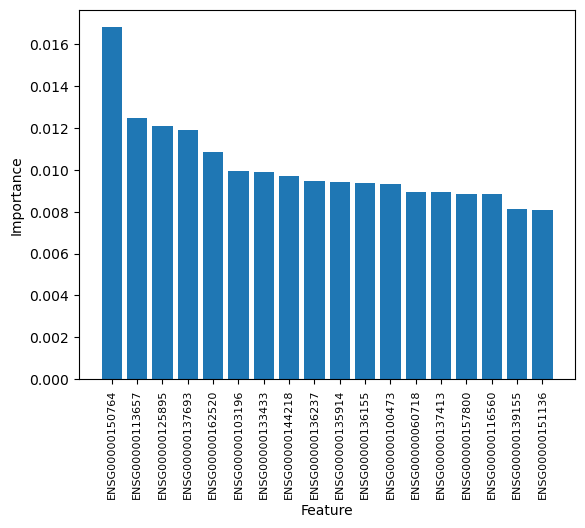

In [30]:

# Create the feature importance plot
plt.bar(sort_feature_df["genes"][0:18,], sort_feature_df["importance"][0:18,])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90,fontsize=8)
plt.show()

In [31]:
sort_feature_df["genes"][0:18,]

192    ENSG00000150764
56     ENSG00000113657
87     ENSG00000125895
140    ENSG00000137693
235    ENSG00000162520
39     ENSG00000103196
115    ENSG00000133433
168    ENSG00000144218
126    ENSG00000136237
124    ENSG00000135914
125    ENSG00000136155
31     ENSG00000100473
9      ENSG00000060718
136    ENSG00000137413
216    ENSG00000157800
62     ENSG00000116560
148    ENSG00000139155
193    ENSG00000151136
Name: genes, dtype: object

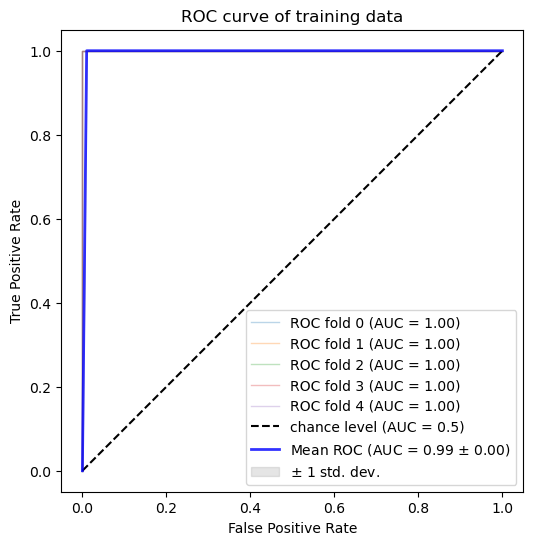

In [32]:
model = rf_model
label="ROC curve of training data"
X_train = pd.DataFrame(X_train)
roc(X_train,y_train,model,label)

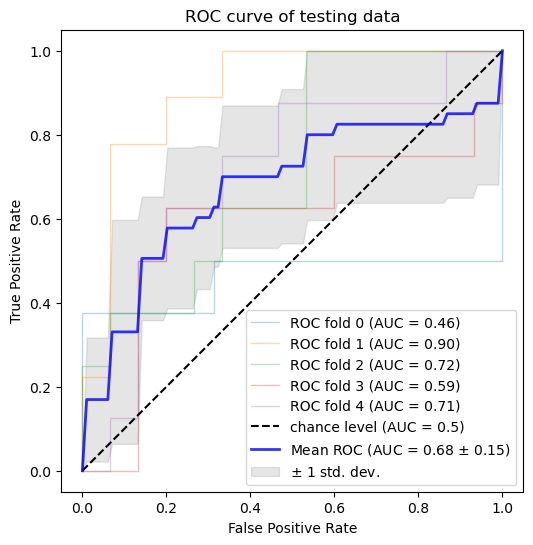

In [33]:
model = rf_model
label="ROC curve of testing data"
X_test_pd = pd.DataFrame(X_test)
roc(X_test_pd,y_test,model,label)

In [34]:
from sklearn.linear_model import RidgeClassifier
model=RidgeClassifier()
param_grid = {'alpha':[0.001,0.01,0.1,1 ]}
rd_model = training(X_train,y_train,model,param_grid)
y_predict = rf_model.predict(X_test)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test,y_predict))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        76
           1       0.60      0.44      0.51        41

    accuracy                           0.70       117
   macro avg       0.67      0.64      0.65       117
weighted avg       0.69      0.70      0.69       117

[[64 12]
 [23 18]]


In [35]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([76, 41]))

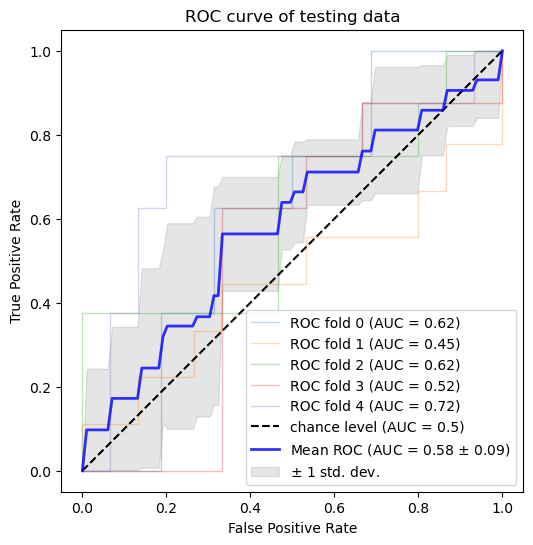

In [36]:
model = rd_model
label="ROC curve of testing data"
X_test_pd = pd.DataFrame(X_test)
roc(X_test_pd,y_test,model,label)

In [37]:
model = xgb.XGBClassifier(random_state=42)

# Defining parameter range
param_grid = {
    'max_depth': [3],
    'learning_rate': [0.1 ,0.01, 0.001],
    'n_estimators': [100],
    'gamma': [ 0.1,0.01,0.001],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [ 0.5, 0.8]
}
xgb_model = training(X_train,y_train,model,param_grid)
y_predict = rf_model.predict(X_test)
y_train_predict = rf_model.predict(X_train)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_train, y_train_predict))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        76
           1       0.60      0.44      0.51        41

    accuracy                           0.70       117
   macro avg       0.67      0.64      0.65       117
weighted avg       0.69      0.70      0.69       117

[[64 12]
 [23 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00       113

    accuracy                           1.00       226
   macro avg       1.00      1.00      1.00       226
weighted avg       1.00      1.00      1.00       226



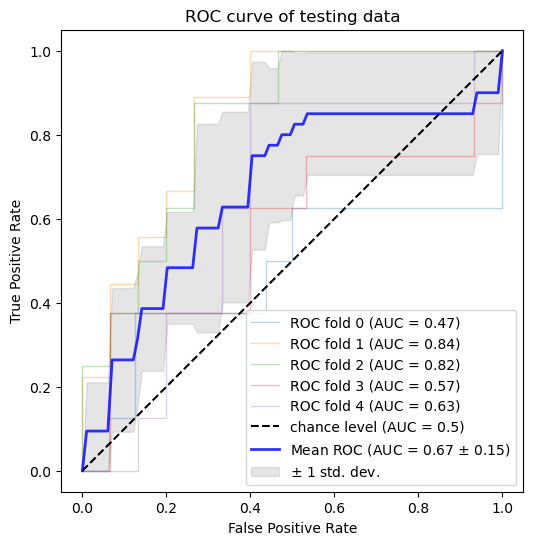

In [38]:
model = xgb_model
label="ROC curve of testing data"
X_test_pd = pd.DataFrame(X_test)
roc(X_test_pd,y_test,model,label)